In [5]:
from CATH_S40_Dataset import *
from utils import *

In [3]:
dataset = CATH_S40_Dataset()
mini_dataset = dataset[:10]

In [4]:
import torch.nn as nn

class EGNNConv(nn.Module):
    r"""Equivariant Graph Convolutional Layer from `E(n) Equivariant Graph
    Neural Networks <https://arxiv.org/abs/2102.09844>`__

    .. math::

        m_{ij}=\phi_e(h_i^l, h_j^l, ||x_i^l-x_j^l||^2, a_{ij})

        x_i^{l+1} = x_i^l + C\sum_{j\in\mathcal{N}(i)}(x_i^l-x_j^l)\phi_x(m_{ij})

        m_i = \sum_{j\in\mathcal{N}(i)} m_{ij}

        h_i^{l+1} = \phi_h(h_i^l, m_i)

    where :math:`h_i`, :math:`x_i`, :math:`a_{ij}` are node features, coordinate
    features, and edge features respectively. :math:`\phi_e`, :math:`\phi_h`, and
    :math:`\phi_x` are two-layer MLPs. :math:`C` is a constant for normalization,
    computed as :math:`1/|\mathcal{N}(i)|`.

    Parameters
    ----------
    in_size : int
        Input feature size; i.e. the size of :math:`h_i^l`.
    hidden_size : int
        Hidden feature size; i.e. the size of hidden layer in the two-layer MLPs in
        :math:`\phi_e, \phi_x, \phi_h`.
    out_size : int
        Output feature size; i.e. the size of :math:`h_i^{l+1}`.
    edge_feat_size : int, optional
        Edge feature size; i.e. the size of :math:`a_{ij}`. Default: 0.

    Example
    -------
    >>> import dgl
    >>> import torch as th
    >>> from dgl.nn import EGNNConv
    >>>
    >>> g = dgl.graph(([0,1,2,3,2,5], [1,2,3,4,0,3]))
    >>> node_feat, coord_feat, edge_feat = th.ones(6, 10), th.ones(6, 3), th.ones(6, 2)
    >>> conv = EGNNConv(10, 10, 10, 2)
    >>> h, x = conv(g, node_feat, coord_feat, edge_feat)
    """

    def __init__(self, in_size, hidden_size, out_size, edge_feat_size=0):
        super(EGNNConv, self).__init__()

        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.edge_feat_size = edge_feat_size
        act_fn = nn.SiLU()

        # \phi_e
        self.edge_mlp = nn.Sequential(
            # +1 for the radial feature: ||x_i - x_j||^2
            nn.Linear(in_size * 2 + edge_feat_size + 1, hidden_size),
            act_fn,
            nn.Linear(hidden_size, hidden_size),
            act_fn,
        )

        # \phi_h
        self.node_mlp = nn.Sequential(
            nn.Linear(in_size + hidden_size, hidden_size),
            act_fn,
            nn.Linear(hidden_size, out_size),
        )

        # \phi_x
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            act_fn,
            nn.Linear(hidden_size, 1, bias=False),
        )

    def message(self, edges):
        """message function for EGNN"""
        # concat features for edge mlp
        if self.edge_feat_size > 0:
            f = torch.cat(
                [
                    edges.src["h"],
                    edges.dst["h"],
                    edges.data["radial"],
                    edges.data["a"],
                ],
                dim=-1,
            )
        else:
            f = torch.cat(
                [edges.src["h"], edges.dst["h"], edges.data["radial"]], dim=-1
            )

        msg_h = self.edge_mlp(f)
        msg_x = self.coord_mlp(msg_h) * edges.data["x_diff"]

        return {"msg_x": msg_x, "msg_h": msg_h}

    def forward(self, graph, node_feat, coord_feat, edge_feat=None):
        r"""
        Description
        -----------
        Compute EGNN layer.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        node_feat : torch.Tensor
            The input feature of shape :math:`(N, h_n)`. :math:`N` is the number of
            nodes, and :math:`h_n` must be the same as in_size.
        coord_feat : torch.Tensor
            The coordinate feature of shape :math:`(N, h_x)`. :math:`N` is the
            number of nodes, and :math:`h_x` can be any positive integer.
        edge_feat : torch.Tensor, optional
            The edge feature of shape :math:`(M, h_e)`. :math:`M` is the number of
            edges, and :math:`h_e` must be the same as edge_feat_size.

        Returns
        -------
        node_feat_out : torch.Tensor
            The output node feature of shape :math:`(N, h_n')` where :math:`h_n'`
            is the same as out_size.
        coord_feat_out: torch.Tensor
            The output coordinate feature of shape :math:`(N, h_x)` where :math:`h_x`
            is the same as the input coordinate feature dimension.
        """
        with graph.local_scope():
            # node feature
            graph.ndata["h"] = node_feat
            # coordinate feature
            graph.ndata["x"] = coord_feat
            # edge feature
            if self.edge_feat_size > 0:
                assert edge_feat is not None, "Edge features must be provided."
                graph.edata["a"] = edge_feat
            # get coordinate diff & radial features
            graph.apply_edges(fn.u_sub_v("x", "x", "x_diff"))
            graph.edata["radial"] = (
                graph.edata["x_diff"].square().sum(dim=1).unsqueeze(-1)
            )
            # normalize coordinate difference
            graph.edata["x_diff"] = F.normalize(graph.edata["x_diff"], p=2, dim=1)
            # graph.edata["x_diff"] = graph.edata["x_diff"] / (
            #     graph.edata["radial"].sqrt() + 1e-30
            # )
            
            graph.apply_edges(self.message)
            graph.update_all(fn.copy_e("msg_x", "m"), fn.mean("m", "x_neigh"))
            graph.update_all(fn.copy_e("msg_h", "m"), fn.sum("m", "h_neigh"))

            h_neigh, x_neigh = graph.ndata["h_neigh"], graph.ndata["x_neigh"]

            h = self.node_mlp(torch.cat([node_feat, h_neigh], dim=-1))
            x = coord_feat + x_neigh

            return h, x

class LGN(nn.Module):

    def __init__(self, in_size, hidden_size, out_size, edge_feat_size, pred_size=2):
        super(LGN, self).__init__()

        self.egc_stack = dgl.nn.pytorch.Sequential()
        self.egc_stack.append(EGNNConv(in_size, hidden_size, out_size, edge_feat_size))
        for _ in range(5):
            self.egc_stack.append(EGNNConv(in_size, hidden_size, out_size))

        self.fully_connected = nn.Linear(in_size, pred_size)

    def forward(self, g, h, x, e):
        h, _ = self.egc_stack(g, h.float(), x, e)
        h = self.fully_connected(h)
        return h

g = mini_dataset[0]

model = LGN(g.ndata['h'].shape[1], 10, g.ndata['h'].shape[1], g.edata['e'].shape[1], 22)
h = model(g, g.ndata['h'], g.ndata['X'], g.edata['e'])

h.shape

/Users/abr/miniconda3/envs/GRL/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


torch.Size([190, 22])

In [6]:
# Hyperparameters
p = 0.6
eps = 0.1
l1 = 0.0001
l2 = 0.0005

g = mini_dataset[0]
model = LGN(g.ndata['h'].shape[1], 10, g.ndata['h'].shape[1], g.edata['e'].shape[1], 22)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
model.float()

b62 = F.normalize(2 ** (torch.tensor(blosum62) / 2))
def blosum(one_hot: torch.Tensor) -> torch.Tensor:
    """Evaluate BLOSUM62 distributions for 1-hot encoded amino acids.
    
    Parameters
    ----------
    one_hot : torch.Tensor
        1-hot encoded amino acids of shape (N, 20).
    
    Returns
    -------
    torch.Tensor
        BLOSUM62 distributions of shape (N, 20).
    """
    return (one_hot @ b62.unsqueeze(0).float()).squeeze(0)

class LossFn(nn.Module):
    def __init__(self):
        super(LossFn, self).__init__()

    def forward(self, pred: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """Multi-task loss function.
        
        Parameters
        ----------
        pred : torch.Tensor
            Predictions of shape (N, 22).
        labels : torch.Tensor
            Labels of shape (N, 22).

        Returns
        -------
        torch.Tensor
            Loss value.
        """
        aa_pred = pred[:, :20]
        bfactor_pred = pred[:, 20]
        sasa_pred = pred[:, 21]

        Laa = -torch.sum(((1-eps) * labels[:, :20] + eps * blosum(labels[:, :20])) * F.log_softmax(aa_pred, dim=1))
        Lbfactor = F.mse_loss(bfactor_pred, labels[:, 20])
        Lsasa = F.mse_loss(sasa_pred, labels[:, 21])

        return Laa + l1 * Lsasa + l2 * Lbfactor

loss_fn = LossFn()
for epoch in range(300):
    total_loss = 0
    for g in mini_dataset:
        labels  = g.ndata['h'][:, :22]
        h = g.ndata['h'].clone()
        h[:, :20] = p * h[:, :20] + (1 - p) * 0.05
        # Zero out the bfactor and sasa features
        h[:, 20] = 0
        h[:, 21] = 0
        x = g.ndata['X']
        e = g.edata['e']

        pred = model(g, h, x, e)
        loss = loss_fn(pred.float(), labels.float())
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 4)
        opt.step()
        total_loss += loss.item()

    if epoch % 5 == 0:
        print(f'Epoch {epoch:3d}\ttrain loss: {total_loss:.2f}')

Epoch   0	train loss: 5631.20
Epoch   5	train loss: 5479.51
Epoch  10	train loss: 5451.31
Epoch  15	train loss: 5066.93
Epoch  20	train loss: 4702.22
Epoch  25	train loss: 4307.96
Epoch  30	train loss: 4037.10
Epoch  35	train loss: 3888.56
Epoch  40	train loss: 3738.04
Epoch  45	train loss: 3575.58
Epoch  50	train loss: 3446.97
Epoch  55	train loss: 3281.07
Epoch  60	train loss: 3479.80
Epoch  65	train loss: 3218.06
Epoch  70	train loss: 3049.62
Epoch  75	train loss: 3117.85
Epoch  80	train loss: 3123.36
Epoch  85	train loss: 2928.15
Epoch  90	train loss: 3527.15
Epoch  95	train loss: 3364.93
Epoch 100	train loss: 2929.13
Epoch 105	train loss: 3003.48
Epoch 110	train loss: 3194.43
Epoch 115	train loss: 2804.52
Epoch 120	train loss: 2714.26
Epoch 125	train loss: 2867.84
Epoch 130	train loss: 2803.65
Epoch 135	train loss: 2740.29
Epoch 140	train loss: 2639.82
Epoch 145	train loss: 2852.00
Epoch 150	train loss: 2588.07
Epoch 155	train loss: 2569.88
Epoch 160	train loss: 2520.91
Epoch 165	

In [ ]:
# I wrote this, and then realised dgl has an implemtation of it already...

class EGC(nn.Module):
    """Equivariant Graph Convolution layer
    
    Parameters
    ----------
    nfeats : int
        Number of input node features.
    efeats : int
        Number of input edge features.
    mfeats : int
        Number of message features (hyperparam).
    phi_e_hidden_dim : int
        Hidden dimension of the edge feature MLP. (hyperparam)
    """

    def __init__(self, nfeats, efeats, mfeats, phi_e_hidden_dim):
        super(EGC, self).__init__()
        self.MLPe = nn.Sequential(
            nn.Linear(nfeats*2+1+efeats, phi_e_hidden_dim),
            nn.ReLU(),
            nn.Linear(phi_e_hidden_dim, mfeats)
        )
        self.MLPx = nn.Sequential(
            nn.ReLU(),
            nn.Linear(mfeats, 1)
        )
        self.MLPh = nn.Sequential(
            nn.Linear(nfeats+mfeats, nfeats)
        )

    def apply_edges(self, edges):
        dx = edges.src['X'] - edges.dst['X']
        e = torch.hstack((edges.src['h'], edges.dst['h'], torch.linalg.norm(dx, dim=-1, keepdim=True) ** 2, edges.data['e'])).to(torch.float32)
        return {'e': self.MLPe(e), 'dx': dx}
    
    def reduce(self, nodes):
        return {'X': nodes.data['X'] + torch.mean(self.MLPx(nodes.mailbox['e']) * nodes.mailbox['dx'], dim=1).squeeze(1),
                'h': self.MLPh(torch.hstack((nodes.data['h'], nodes.mailbox['e'].sum(1))).to(torch.float32)).squeeze()}

    def forward(self, g, h, e, x):
        """Forward computation
        
        Parameters
        ----------
        g : DGLGraph
            The graph.
        h : torch.Tensor
            The input node features.
        e : torch.Tensor
            The input edge features.
        x : torch.Tensor
            The input node coordinates.
        """

        # Pass messages to edges
        with g.local_scope():
            g.ndata['h'] = h
            g.edata['e'] = e
            g.ndata['X'] = x
            g.update_all(
                message_func=self.apply_edges,
                reduce_func=self.reduce
            )
            return g.ndata['h'], g.ndata['e'], g.ndata['X']

/var/folders/hj/l947w2kj47v3cl_f2yb2twhh0000gn/T/ipykernel_25930/1630563767.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


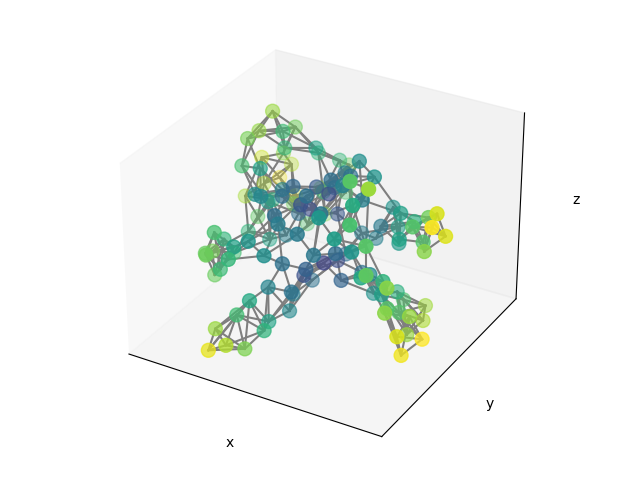

In [17]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

# The graph to visualize
g = dataset.graphs[2]
g.update_all(fn.v_sub_u('X', 'X', 'Xv-Xu'), mean_forces)

G = g.to_networkx().to_undirected()

# 3d spring layout
# pos = nx.spring_layout(G, dim=3, seed=779)
pos = g.ndata['X'].detach().numpy()

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
# fc = np.vstack([g.ndata["rho"].detach().numpy()[:, 3], np.zeros(g.ndata["rho"].shape[0]), np.zeros(g.ndata["rho"].shape[0])]).T

x = g.ndata["X"].detach().numpy()
com = np.sum(x, axis=0) / x.shape[0]
x -= com

import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')

ax.scatter(*node_xyz.T, s=100, 
           fc=cmap(np.linalg.norm(x, axis=-1) / np.max(np.linalg.norm(x, axis=-1))))
           # fc=cmap(g.ndata["h"][:, 20].detach().numpy()/100)) # BFactor
           # fc=cmap(g.ndata["h"][:, 21].detach().numpy()/100)) # SASA
           # fc=cmap(np.linspace(0, 1, g.ndata["X"].shape[0])))
           # fc=cmap(g.ndata["_ID"].detach().numpy()))

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()


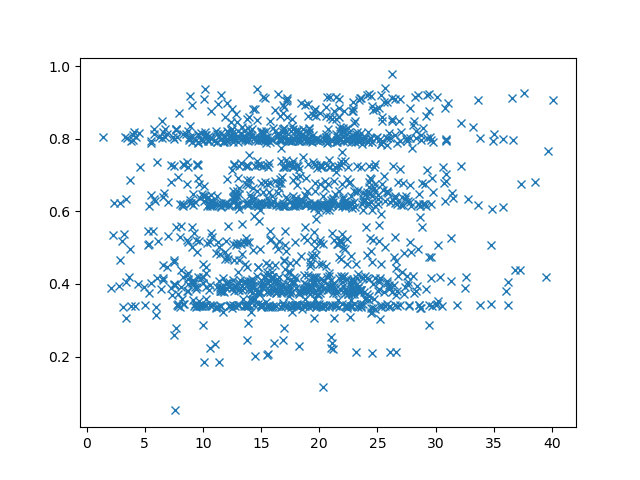

In [ ]:
x = g.ndata["X"].detach().numpy()
com = np.sum(x, axis=0) / x.shape[0]
x -= com

plt.figure()
plt.plot(np.linalg.norm(x, axis=1), g.ndata["rho"].detach().numpy()[:, 4], 'x')
plt.show()